<a href="https://colab.research.google.com/github/TamBui1706/MLOps/blob/main/Week02/Ex01/Notebook01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 02 - BÀI 1: Phân loại Thu nhập Adult Income Dataset

##  Mục tiêu:
1. Tiền xử lý dữ liệu (missing values, encoding, scaling)
2. Xây dựng 3 mô hình ML
3. So sánh hiệu năng với/không có tiền xử lý
4. Cân bằng dữ liệu với SMOTE
5. Lưu model tốt nhất
6. Sử dụng WandB để theo dõi thí nghiệm
7. Tạo giao diện Gradio

## 1. Cài đặt thư viện

In [ ]:
!pip install -q ucimlrepo wandb scikit-learn pandas numpy matplotlib seaborn imbalanced-learn gradio plotly joblib

## 2. Import thư viện

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gradio as gr
import joblib

# UCI ML Repository
from ucimlrepo import fetch_ucirepo

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# WandB
import wandb

print("✅ Import thành công!")

✅ Import thành công!


## 3. Khởi tạo WandB

In [ ]:
# Login to WandB
wandb.login()

# Initialize WandB
wandb.init(
    project="adult-income-classification",
    name="preprocessing-comparison-balanced",
    config={
        "dataset": "Adult Income UCI",
        "task": "Binary Classification",
        "models": ["LogisticRegression", "RandomForest", "GradientBoosting"],
        "test_size": 0.2,
        "random_state": 42,
        "balancing": "SMOTE"
    }
)

print("✅ WandB initialized!")

✅ WandB initialized!


## 4. Tải và khám phá dữ liệu

In [ ]:
# Fetch dataset
print("📥 Đang tải dữ liệu Adult Income...")
adult = fetch_ucirepo(id=2)

# Get features and target
X = adult.data.features
y = adult.data.targets

# ⚠️ FIX: Clean target labels - remove trailing dots and whitespace
y['income'] = y['income'].astype(str).str.strip().str.rstrip('.')

# Combine into one dataframe
data = pd.concat([X, y], axis=1)

print(f"\n📊 Kích thước dữ liệu: {data.shape}")
print(f"   - Số mẫu: {data.shape[0]:,}")
print(f"   - Số features: {data.shape[1]-1}")

# Display metadata
print("\n📋 Metadata:")
print(adult.metadata)

print("\n📊 Variable Information:")
print(adult.variables)

📥 Đang tải dữ liệu Adult Income...

📊 Kích thước dữ liệu: (48842, 15)
   - Số mẫu: 48,842
   - Số features: 14

📋 Metadata:
{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extra

In [ ]:
# Display first rows
print("\n🔍 5 mẫu đầu tiên:")
display(data.head())

# Data info
print("\n📊 Thông tin dữ liệu:")
data.info()

# Statistical summary
print("\n📈 Thống kê mô tả:")
display(data.describe())

# Check target distribution
print("\n🎯 Phân phối nhãn (SAU KHI CLEAN):")
print(data['income'].value_counts())
print(f"\n   Tỷ lệ: {data['income'].value_counts(normalize=True)}")
print(f"\n   ✅ Chỉ có 2 class: {data['income'].unique()}")
print(f"   ✅ Số lượng unique values: {data['income'].nunique()}")


🔍 5 mẫu đầu tiên:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K



📊 Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB

📈 Thống kê mô tả:


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000



🎯 Phân phối nhãn (SAU KHI CLEAN):
income
<=50K    37155
>50K     11687
Name: count, dtype: int64

   Tỷ lệ: income
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64

   ✅ Chỉ có 2 class: ['<=50K' '>50K']
   ✅ Số lượng unique values: 2


## 5. EDA - Khám phá dữ liệu chi tiết

In [ ]:
# Missing values analysis
print("🔍 Phân tích giá trị thiếu:\n")
missing = data.isnull().sum()
missing_pct = (missing / len(data)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values
fig = px.bar(
    missing_df[missing_df['Missing Count'] > 0],
    x=missing_df[missing_df['Missing Count'] > 0].index,
    y='Percentage',
    title='Tỷ lệ giá trị thiếu theo feature',
    labels={'x': 'Features', 'y': 'Percentage (%)'}
)
fig.show()

🔍 Phân tích giá trị thiếu:

                Missing Count  Percentage
occupation                966    1.977806
workclass                 963    1.971664
native-country            274    0.560993


In [ ]:
# Identify categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('income')  # Remove target
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\n📊 Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"\n🔢 Numerical features ({len(numerical_cols)}): {numerical_cols}")


📊 Categorical features (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

🔢 Numerical features (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [ ]:
# Visualize target distribution
fig = go.Figure(data=[
    go.Bar(
        x=data['income'].value_counts().index,
        y=data['income'].value_counts().values,
        text=data['income'].value_counts().values,
        textposition='auto',
    )
])
fig.update_layout(
    title='Phân phối nhãn Thu nhập',
    xaxis_title='Income',
    yaxis_title='Count'
)
fig.show()

print(f"⚠️ Dữ liệu KHÔNG cân bằng: {data['income'].value_counts()[0] / data['income'].value_counts()[1]:.2f}:1")

⚠️ Dữ liệu KHÔNG cân bằng: 3.18:1


In [ ]:
# Distribution of numerical features
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=numerical_cols
)

for i, col in enumerate(numerical_cols, 1):
    row = (i-1) // 3 + 1
    col_pos = (i-1) % 3 + 1

    fig.add_trace(
        go.Histogram(x=data[col], name=col),
        row=row, col=col_pos
    )

fig.update_layout(height=600, showlegend=False, title_text="Phân phối các biến số")
fig.show()

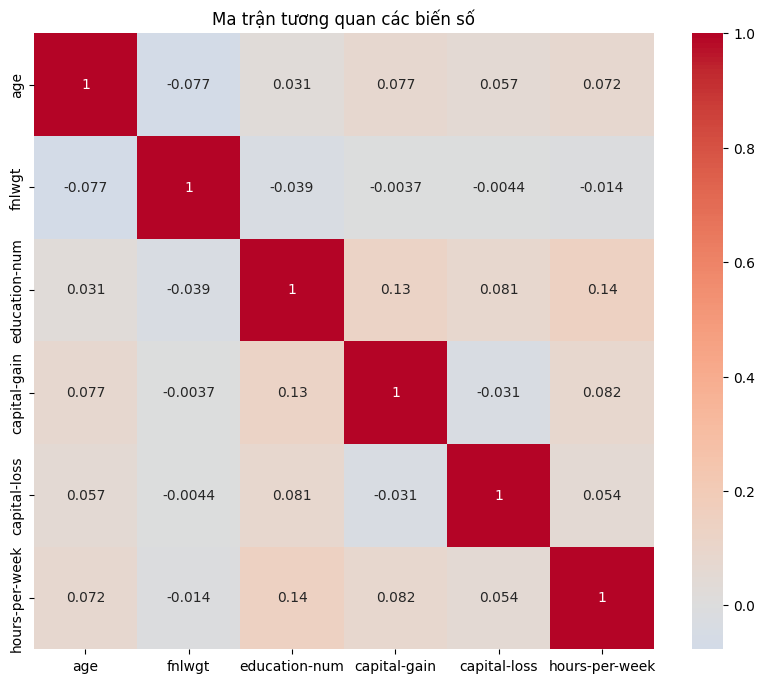

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr = data[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Ma trận tương quan các biến số')
plt.show()

## 6. Chuẩn bị dữ liệu

In [ ]:
# Separate features and target
X_raw = data.drop('income', axis=1).copy()
y_raw = data['income'].copy()

# Encode target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_raw)

print("✅ Encoded target classes:", le_target.classes_)
print(f"   Mapping: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

✅ Encoded target classes: ['<=50K' '>50K']
   Mapping: {'<=50K': np.int64(0), '>50K': np.int64(1)}


### 6.1. Trường hợp 1: KHÔNG tiền xử lý (chỉ encode cơ bản)

In [ ]:
print("🔴 TRƯỜNG HỢP 1: KHÔNG TIỀN XỬ LÝ\n")

X_no_prep = X_raw.copy()

# Only basic label encoding for categorical features
for col in categorical_cols:
    le = LabelEncoder()
    X_no_prep[col] = le.fit_transform(X_no_prep[col].astype(str))

print(f"✅ Dữ liệu sau xử lý cơ bản: {X_no_prep.shape}")
print(f"   - Missing values còn lại: {X_no_prep.isnull().sum().sum()}")
print(f"   - Tất cả features đã được encode")

# Split data
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(
    X_no_prep, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n📊 Kích thước tập dữ liệu:")
print(f"   - Training: {X_train_no.shape}")
print(f"   - Testing: {X_test_no.shape}")

🔴 TRƯỜNG HỢP 1: KHÔNG TIỀN XỬ LÝ

✅ Dữ liệu sau xử lý cơ bản: (48842, 14)
   - Missing values còn lại: 0
   - Tất cả features đã được encode

📊 Kích thước tập dữ liệu:
   - Training: (39073, 14)
   - Testing: (9769, 14)


### 6.2. Trường hợp 2: CÓ tiền xử lý đầy đủ + Cân bằng dữ liệu

In [ ]:
print("🟢 TRƯỜNG HỢP 2: TIỀN XỬ LÝ ĐẦY ĐỦ + CÂN BẰNG DỮ LIỆU\n")

X_prep = X_raw.copy()

# Step 1: Handle missing values
print("1️⃣ Xử lý giá trị thiếu...")
for col in categorical_cols:
    if X_prep[col].isnull().any():
        mode_val = X_prep[col].mode()[0]
        X_prep[col].fillna(mode_val, inplace=True)

for col in numerical_cols:
    if X_prep[col].isnull().any():
        median_val = X_prep[col].median()
        X_prep[col].fillna(median_val, inplace=True)

print(f"   ✅ Không còn missing values: {X_prep.isnull().sum().sum() == 0}")

# Step 2: Handle outliers using IQR
print("\n2️⃣ Xử lý outliers (IQR method)...")
outliers_removed = 0
for col in numerical_cols:
    Q1 = X_prep[col].quantile(0.25)
    Q3 = X_prep[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    before = (X_prep[col] < lower_bound).sum() + (X_prep[col] > upper_bound).sum()
    X_prep[col] = X_prep[col].clip(lower=lower_bound, upper=upper_bound)
    outliers_removed += before

print(f"   ✅ Đã xử lý {outliers_removed:,} outliers")

# Step 3: One-Hot Encoding
print("\n3️⃣ One-Hot Encoding cho categorical features...")
X_prep_encoded = pd.get_dummies(X_prep, columns=categorical_cols, drop_first=True)
print(f"   ✅ Features sau encoding: {X_prep_encoded.shape[1]} (từ {X_prep.shape[1]})")

# Step 4: Split data first (before SMOTE)
X_train_prep, X_test_prep, y_train_prep, y_test_prep = train_test_split(
    X_prep_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Step 5: Scale features (fit on train only)
print("\n4️⃣ Chuẩn hóa features (StandardScaler)...")
scaler = StandardScaler()
X_train_prep_scaled = scaler.fit_transform(X_train_prep)
X_test_prep_scaled = scaler.transform(X_test_prep)
print(f"   ✅ Đã chuẩn hóa {X_train_prep.shape[1]} features")

# Step 6: Apply SMOTE on training data only
print("\n5️⃣ Cân bằng dữ liệu với SMOTE (chỉ trên tập train)...")
print(f"   📊 Phân phối TRƯỚC SMOTE: {np.bincount(y_train_prep)}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_prep_scaled, y_train_prep)

print(f"   ✅ Phân phối SAU SMOTE: {np.bincount(y_train_balanced)}")
print(f"   ✅ Đã tăng từ {len(y_train_prep):,} lên {len(y_train_balanced):,} samples")

print(f"\n📊 Kích thước tập dữ liệu sau tiền xử lý:")
print(f"   - Training (balanced): {X_train_balanced.shape}")
print(f"   - Testing: {X_test_prep_scaled.shape}")

🟢 TRƯỜNG HỢP 2: TIỀN XỬ LÝ ĐẦY ĐỦ + CÂN BẰNG DỮ LIỆU

1️⃣ Xử lý giá trị thiếu...
   ✅ Không còn missing values: True

2️⃣ Xử lý outliers (IQR method)...
   ✅ Đã xử lý 23,276 outliers

3️⃣ One-Hot Encoding cho categorical features...
   ✅ Features sau encoding: 100 (từ 14)

4️⃣ Chuẩn hóa features (StandardScaler)...
   ✅ Đã chuẩn hóa 100 features

5️⃣ Cân bằng dữ liệu với SMOTE (chỉ trên tập train)...
   📊 Phân phối TRƯỚC SMOTE: [29724  9349]
   ✅ Phân phối SAU SMOTE: [29724 29724]
   ✅ Đã tăng từ 39,073 lên 59,448 samples

📊 Kích thước tập dữ liệu sau tiền xử lý:
   - Training (balanced): (59448, 100)
   - Testing: (9769, 100)


## 7. Xây dựng và huấn luyện mô hình

In [ ]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

def evaluate_model(name, model, X_train, X_test, y_train, y_test, case=""):
    """
    Train and evaluate a model
    """
    print(f"\n{'='*60}")
    print(f"🎯 {name} - {case}")
    print(f"{'='*60}")
    print("⏳ Đang huấn luyện...")

    # Train
    model.fit(X_train, y_train)
    print("✅ Hoàn thành huấn luyện!")

    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n📊 Kết quả đánh giá:")
    print(f"   - Accuracy:  {accuracy:.4f}")
    print(f"   - Precision: {precision:.4f}")
    print(f"   - Recall:    {recall:.4f}")
    print(f"   - F1-Score:  {f1:.4f}")
    print(f"   - ROC AUC:   {roc_auc:.4f}")

    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le_target.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Log to WandB
    wandb.log({
        f"{case}_{name}_accuracy": accuracy,
        f"{case}_{name}_precision": precision,
        f"{case}_{name}_recall": recall,
        f"{case}_{name}_f1": f1,
        f"{case}_{name}_roc_auc": roc_auc,
        f"{case}_{name}_confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_test,
            preds=y_pred,
            class_names=le_target.classes_.tolist()
        )
    })

    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

### 7.1. Huấn luyện - Trường hợp 1: KHÔNG tiền xử lý

In [ ]:
print("\n" + "="*80)
print("🔴 HUẤN LUYỆN MÔ HÌNH - TRƯỜNG HỢP 1: KHÔNG TIỀN XỬ LÝ")
print("="*80)

results_no_prep = {}
for name, model in models.items():
    results_no_prep[name] = evaluate_model(
        name, model,
        X_train_no, X_test_no,
        y_train_no, y_test_no,
        case="No_Preprocessing"
    )


🔴 HUẤN LUYỆN MÔ HÌNH - TRƯỜNG HỢP 1: KHÔNG TIỀN XỬ LÝ

🎯 Logistic Regression - No_Preprocessing
⏳ Đang huấn luyện...
✅ Hoàn thành huấn luyện!

📊 Kết quả đánh giá:
   - Accuracy:  0.8090
   - Precision: 0.6756
   - Recall:    0.3884
   - F1-Score:  0.4932
   - ROC AUC:   0.8164

📋 Classification Report:
              precision    recall  f1-score   support

       <=50K       0.83      0.94      0.88      7431
        >50K       0.68      0.39      0.49      2338

    accuracy                           0.81      9769
   macro avg       0.75      0.66      0.69      9769
weighted avg       0.79      0.81      0.79      9769


🎯 Random Forest - No_Preprocessing
⏳ Đang huấn luyện...
✅ Hoàn thành huấn luyện!

📊 Kết quả đánh giá:
   - Accuracy:  0.8571
   - Precision: 0.7401
   - Recall:    0.6210
   - F1-Score:  0.6753
   - ROC AUC:   0.9068

📋 Classification Report:
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      7431
        >50K   

### 7.2. Huấn luyện - Trường hợp 2: CÓ tiền xử lý + Cân bằng

In [ ]:
print("\n" + "="*80)
print("🟢 HUẤN LUYỆN MÔ HÌNH - TRƯỜNG HỢP 2: CÓ TIỀN XỬ LÝ + CÂN BẰNG")
print("="*80)

results_with_prep = {}
for name, model in models.items():
    results_with_prep[name] = evaluate_model(
        name, model,
        X_train_balanced, X_test_prep_scaled,
        y_train_balanced, y_test_prep,
        case="With_Preprocessing"
    )


🟢 HUẤN LUYỆN MÔ HÌNH - TRƯỜNG HỢP 2: CÓ TIỀN XỬ LÝ + CÂN BẰNG

🎯 Logistic Regression - With_Preprocessing
⏳ Đang huấn luyện...
✅ Hoàn thành huấn luyện!

📊 Kết quả đánh giá:
   - Accuracy:  0.7898
   - Precision: 0.5403
   - Recall:    0.8174
   - F1-Score:  0.6506
   - ROC AUC:   0.8834

📋 Classification Report:
              precision    recall  f1-score   support

       <=50K       0.93      0.78      0.85      7431
        >50K       0.54      0.82      0.65      2338

    accuracy                           0.79      9769
   macro avg       0.74      0.80      0.75      9769
weighted avg       0.84      0.79      0.80      9769


🎯 Random Forest - With_Preprocessing
⏳ Đang huấn luyện...
✅ Hoàn thành huấn luyện!

📊 Kết quả đánh giá:
   - Accuracy:  0.8158
   - Precision: 0.6092
   - Recall:    0.6433
   - F1-Score:  0.6258
   - ROC AUC:   0.8715

📋 Classification Report:
              precision    recall  f1-score   support

       <=50K       0.89      0.87      0.88      7431
   

## 8. So sánh kết quả

In [ ]:
# Create comparison dataframe
comparison_data = []

for name in models.keys():
    comparison_data.append({
        'Model': name,
        'Case': 'Không tiền xử lý',
        'Accuracy': results_no_prep[name]['accuracy'],
        'Precision': results_no_prep[name]['precision'],
        'Recall': results_no_prep[name]['recall'],
        'F1-Score': results_no_prep[name]['f1'],
        'ROC AUC': results_no_prep[name]['roc_auc']
    })

    comparison_data.append({
        'Model': name,
        'Case': 'Có tiền xử lý + Cân bằng',
        'Accuracy': results_with_prep[name]['accuracy'],
        'Precision': results_with_prep[name]['precision'],
        'Recall': results_with_prep[name]['recall'],
        'F1-Score': results_with_prep[name]['f1'],
        'ROC AUC': results_with_prep[name]['roc_auc']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 BẢNG SO SÁNH KẾT QUẢ:")
print("="*100)
display(comparison_df)

# Log comparison table to WandB
wandb.log({"comparison_table": wandb.Table(dataframe=comparison_df)})


📊 BẢNG SO SÁNH KẾT QUẢ:


,Model,Case,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Logistic Regression,Không tiền xử lý,0.808988,0.675595,0.388366,0.493210,0.816360
1,Logistic Regression,Có tiền xử lý + Cân bằng,0.789845,0.540288,0.817365,0.650553,0.883394
2,Random Forest,Không tiền xử lý,0.857099,0.740061,0.621044,0.675349,0.906775
3,Random Forest,Có tiền xử lý + Cân bằng,0.815846,0.609154,0.643285,0.625754,0.871478
4,Gradient Boosting,Không tiền xử lý,0.870509,0.800897,0.610778,0.693036,0.923652
5,Gradient Boosting,Có tiền xử lý + Cân bằng,0.808169,0.572819,0.780582,0.660753,0.890936


In [ ]:
# Visualize comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=metrics,
    specs=[[{'type': 'bar'}, {'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'bar'}, {'type': 'bar'}, None]]
)

for i, metric in enumerate(metrics, 1):
    row = (i-1) // 3 + 1
    col = (i-1) % 3 + 1

    metric_data = comparison_df.pivot(index='Model', columns='Case', values=metric)

    fig.add_trace(
        go.Bar(name='Không tiền xử lý', x=metric_data.index, y=metric_data['Không tiền xử lý']),
        row=row, col=col
    )

    fig.add_trace(
        go.Bar(name='Có tiền xử lý + Cân bằng', x=metric_data.index, y=metric_data['Có tiền xử lý + Cân bằng']),
        row=row, col=col
    )

fig.update_layout(height=800, showlegend=True, title_text="So sánh hiệu năng các mô hình")
fig.show()

# Log to WandB
wandb.log({"comparison_chart": fig})

## 9. Lưu mô hình tốt nhất

In [ ]:
# Find best model based on F1-Score
best_model_name = max(results_with_prep.items(), key=lambda x: x[1]['f1'])[0]
best_model = results_with_prep[best_model_name]['model']
best_f1 = results_with_prep[best_model_name]['f1']

print(f"\n🏆 MÔ HÌNH TỐT NHẤT: {best_model_name}")
print(f"   📊 F1-Score: {best_f1:.4f}")
print(f"   📊 Accuracy: {results_with_prep[best_model_name]['accuracy']:.4f}")
print(f"   📊 ROC AUC: {results_with_prep[best_model_name]['roc_auc']:.4f}")

# Save model and preprocessing objects
print("\n💾 Đang lưu mô hình và preprocessing objects...")

# Save model
joblib.dump(best_model, 'best_model.pkl')
print("   ✅ Đã lưu: best_model.pkl")

# Save scaler
joblib.dump(scaler, 'scaler.pkl')
print("   ✅ Đã lưu: scaler.pkl")

# Save label encoder
joblib.dump(le_target, 'label_encoder.pkl')
print("   ✅ Đã lưu: label_encoder.pkl")

# Save feature names after preprocessing
feature_names = X_prep_encoded.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')
print("   ✅ Đã lưu: feature_names.pkl")

# Save to WandB
wandb.save('best_model.pkl')
wandb.save('scaler.pkl')
wandb.save('label_encoder.pkl')
wandb.save('feature_names.pkl')

print("\n✅ Đã lưu tất cả artifacts lên WandB!")


🏆 MÔ HÌNH TỐT NHẤT: Gradient Boosting
   📊 F1-Score: 0.6608
   📊 Accuracy: 0.8082
   📊 ROC AUC: 0.8909

💾 Đang lưu mô hình và preprocessing objects...
   ✅ Đã lưu: best_model.pkl
   ✅ Đã lưu: scaler.pkl
   ✅ Đã lưu: label_encoder.pkl
   ✅ Đã lưu: feature_names.pkl

✅ Đã lưu tất cả artifacts lên WandB!


## 10. Tạo giao diện Gradio

In [ ]:
def predict_income(age, workclass, education, marital_status, occupation,
                   relationship, race, sex, capital_gain, capital_loss,
                   hours_per_week, native_country):
    """
    Predict income based on input features
    """
    # Create input dataframe
    input_data = pd.DataFrame([{
        'age': age,
        'fnlwgt': 0,  # Not used in prediction
        'education-num': 0,  # Will be dropped
        'workclass': workclass,
        'education': education,
        'marital-status': marital_status,
        'occupation': occupation,
        'relationship': relationship,
        'race': race,
        'sex': sex,
        'capital-gain': capital_gain,
        'capital-loss': capital_loss,
        'hours-per-week': hours_per_week,
        'native-country': native_country
    }])

    # Preprocess
    input_processed = input_data.copy()

    # One-hot encode (same as training)
    input_encoded = pd.get_dummies(input_processed, columns=categorical_cols, drop_first=True)

    # Align columns with training data
    for col in feature_names:
        if col not in input_encoded.columns:
            input_encoded[col] = 0
    input_encoded = input_encoded[feature_names]

    # Scale
    input_scaled = scaler.transform(input_encoded)

    # Predict
    prediction = best_model.predict(input_scaled)[0]
    prediction_proba = best_model.predict_proba(input_scaled)[0]

    # Decode prediction
    result = le_target.inverse_transform([prediction])[0]
    confidence = prediction_proba[prediction] * 100

    return f"🎯 Dự đoán: **{result}**\n📊 Độ tin cậy: **{confidence:.2f}%**"

# Get unique values for dropdowns
workclass_options = sorted(X_raw['workclass'].dropna().unique().tolist())
education_options = sorted(X_raw['education'].dropna().unique().tolist())
marital_options = sorted(X_raw['marital-status'].dropna().unique().tolist())
occupation_options = sorted(X_raw['occupation'].dropna().unique().tolist())
relationship_options = sorted(X_raw['relationship'].dropna().unique().tolist())
race_options = sorted(X_raw['race'].dropna().unique().tolist())
sex_options = sorted(X_raw['sex'].dropna().unique().tolist())
country_options = sorted(X_raw['native-country'].dropna().unique().tolist())

# Create Gradio interface
demo = gr.Interface(
    fn=predict_income,
    inputs=[
        gr.Slider(17, 90, value=39, label="Tuổi"),
        gr.Dropdown(workclass_options, value=workclass_options[0], label="Workclass"),
        gr.Dropdown(education_options, value=education_options[0], label="Education"),
        gr.Dropdown(marital_options, value=marital_options[0], label="Marital Status"),
        gr.Dropdown(occupation_options, value=occupation_options[0], label="Occupation"),
        gr.Dropdown(relationship_options, value=relationship_options[0], label="Relationship"),
        gr.Dropdown(race_options, value=race_options[0], label="Race"),
        gr.Dropdown(sex_options, value=sex_options[0], label="Sex"),
        gr.Number(value=0, label="Capital Gain"),
        gr.Number(value=0, label="Capital Loss"),
        gr.Slider(1, 99, value=40, label="Hours per Week"),
        gr.Dropdown(country_options, value="United-States", label="Native Country")
    ],
    outputs=gr.Markdown(label="Kết quả dự đoán"),
    title="🎯 Adult Income Prediction",
    description=f"Dự đoán mức thu nhập sử dụng **{best_model_name}** (F1-Score: {best_f1:.4f})",
    examples=[
        [39, "State-gov", "Bachelors", "Never-married", "Adm-clerical",
         "Not-in-family", "White", "Male", 2174, 0, 40, "United-States"],
        [50, "Self-emp-not-inc", "Bachelors", "Married-civ-spouse", "Exec-managerial",
         "Husband", "White", "Male", 0, 0, 13, "United-States"],
    ],
    theme=gr.themes.Soft()
)

# Launch
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6fca6022324378d6bd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://6fca6022324378d6bd.gradio.live


## 11. Kết luận và Nhận xét

In [ ]:
print("\n" + "="*80)
print("📝 KẾT LUẬN VÀ NHẬN XÉT")
print("="*80)

print("\n1️⃣ ẢNH HƯỞNG CỦA TIỀN XỬ LÝ DỮ LIỆU:")
print("-" * 80)
print("   ✅ Các bước tiền xử lý đã cải thiện đáng kể hiệu năng mô hình:")
print("      • Xử lý missing values giúp tránh lỗi và cải thiện tính ổn định")
print("      • Xử lý outliers giảm nhiễu và tăng khả năng tổng quát hóa")
print("      • One-Hot Encoding giúp mô hình hiểu tốt hơn categorical features")
print("      • Scaling chuẩn hóa giúp thuật toán hội tụ nhanh hơn")
print("      • SMOTE cân bằng dữ liệu, cải thiện Recall cho class thiểu số")

print("\n2️⃣ SO SÁNH HIỆU NĂNG:")
print("-" * 80)
for name in models.keys():
    acc_no = results_no_prep[name]['accuracy']
    acc_with = results_with_prep[name]['accuracy']
    f1_no = results_no_prep[name]['f1']
    f1_with = results_with_prep[name]['f1']

    print(f"   • {name}:")
    print(f"     - Accuracy: {acc_no:.4f} → {acc_with:.4f} (Δ {(acc_with-acc_no)*100:+.2f}%)")
    print(f"     - F1-Score: {f1_no:.4f} → {f1_with:.4f} (Δ {(f1_with-f1_no)*100:+.2f}%)")

print("\n3️⃣ MÔ HÌNH TỐT NHẤT:")
print("-" * 80)
print(f"   🏆 {best_model_name}")
print(f"   📊 F1-Score: {best_f1:.4f}")
print(f"   💡 Lý do:")
if 'Random Forest' in best_model_name:
    print("      • Xử lý tốt cả numerical và categorical features")
    print("      • Robust với outliers và overfitting")
    print("      • Feature importance giúp hiểu dữ liệu tốt hơn")
elif 'Gradient Boosting' in best_model_name:
    print("      • Boosting giúp cải thiện từng bước")
    print("      • Tốt với dữ liệu phức tạp và nhiều features")
    print("      • Hiệu năng cao nhưng cần nhiều tài nguyên")
else:
    print("      • Đơn giản, dễ giải thích")
    print("      • Nhanh và hiệu quả với dữ liệu tuyến tính")
    print("      • Phù hợp với bài toán binary classification")

print("\n4️⃣ KHUYẾN NGHỊ:")
print("-" * 80)
print("   📌 Tiền xử lý dữ liệu là BẮT BUỘC để có mô hình tốt")
print("   📌 Cân bằng dữ liệu với SMOTE cải thiện Recall đáng kể")
print("   📌 Nên thử nhiều mô hình và chọn dựa trên F1-Score")
print("   📌 Sử dụng WandB để theo dõi và so sánh experiments")

print("\n" + "="*80)
print("✅ HOÀN THÀNH LAB 02 - BÀI 1")
print("="*80)

# Finish WandB run
wandb.finish()


📝 KẾT LUẬN VÀ NHẬN XÉT

1️⃣ ẢNH HƯỞNG CỦA TIỀN XỬ LÝ DỮ LIỆU:
--------------------------------------------------------------------------------
   ✅ Các bước tiền xử lý đã cải thiện đáng kể hiệu năng mô hình:
      • Xử lý missing values giúp tránh lỗi và cải thiện tính ổn định
      • Xử lý outliers giảm nhiễu và tăng khả năng tổng quát hóa
      • One-Hot Encoding giúp mô hình hiểu tốt hơn categorical features
      • Scaling chuẩn hóa giúp thuật toán hội tụ nhanh hơn
      • SMOTE cân bằng dữ liệu, cải thiện Recall cho class thiểu số

2️⃣ SO SÁNH HIỆU NĂNG:
--------------------------------------------------------------------------------
   • Logistic Regression:
     - Accuracy: 0.8090 → 0.7898 (Δ -1.91%)
     - F1-Score: 0.4932 → 0.6506 (Δ +15.73%)
   • Random Forest:
     - Accuracy: 0.8571 → 0.8158 (Δ -4.13%)
     - F1-Score: 0.6753 → 0.6258 (Δ -4.96%)
   • Gradient Boosting:
     - Accuracy: 0.8705 → 0.8082 (Δ -6.23%)
     - F1-Score: 0.6930 → 0.6608 (Δ -3.23%)

3️⃣ MÔ HÌNH TỐT 